# Deep Learning to Decipher Sign Language

## 1. Introduction

Admittedly, various sign languages make it possible for people having difficulties in speaking to express themselves; whereas sign languages do not function all the time, since to understand it, the listeners must be able to decipher the gestures simultaneously. Here comes the idea of using machine learning to translate sign languages to get rid of the constraints related to human efforts; for example, it might be of our great interests to have a plug-in trained by deep learning mechanism, that can capture signs from a video call and translates the signs simultaneously for non-speakers.

In order to prepare ourselves for the development of a complex software, it is crucial to build a machine learning model that is capable of deciphering signs in images. To test out this idea, one sign language where the alphabet and some keyboard inputs (space, delete and nothing) are represented by gestures is chosen as our study object and this Kaggle dataset will be used: https://www.kaggle.com/code/paultimothymooney/interpret-sign-language-with-deep-learning/input

Our objective will be to train a model to be able to predict the character from a gesture in an image. Since we are using labels for machine learning, this falls under the category of supervised learning.

## 2. EDA

#### 2.1 EDA: Visualization and Analysis on Sample Image(s)

The data has been already separated into training set and test set. On one side, for the training set, all the images are grouped in different folders named with the represented character, from which we can tell the label for each image. On the other side, in the test data, there are 28 images, each corresponding to a specific character except the "delete" key. The label for each image in the test set can be extracted from the file name. 

Now that we understand how data are stocked, we can also display an example so that we have an idea on how the images look like and what the dimensions, pixel sizes and number of channels, are. By observing an image, it is apparent that the images are colored which means that it is reasonable to extract the RGB information from the images, instead of merely looking at the grayscale. It is possible to plot the RGB values in a distribution plot, so that we understand how values of the three channels are distributed in an approximate manner, even though that this might not provide us with much useful information.

In [1]:
import shutil

# clean up the working folder
shutil.rmtree('/kaggle/working/', ignore_errors=True)

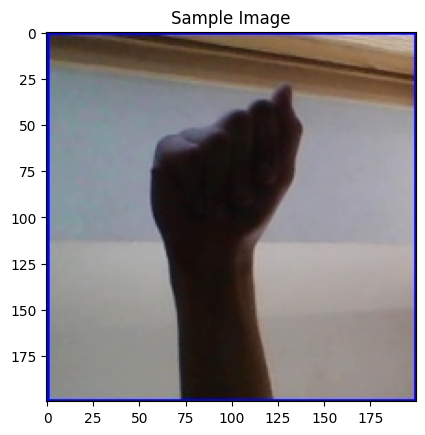

Image shape: (200, 200, 3)


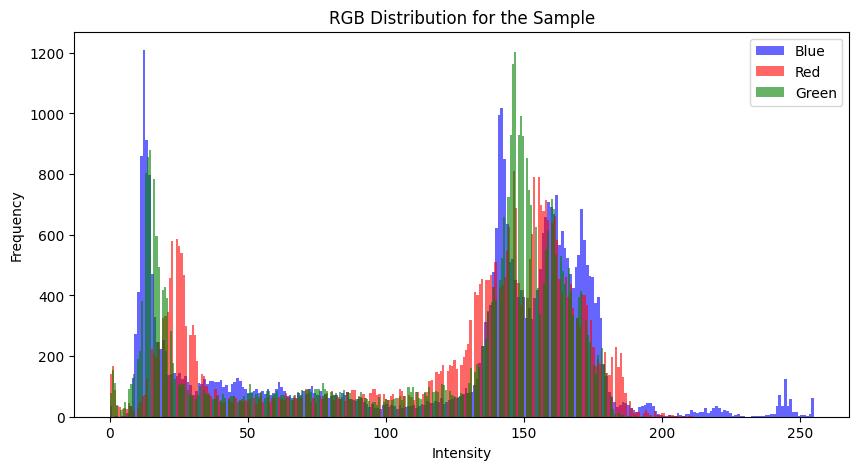

In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# read a sample image
img = mpimg.imread(r'/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg')
plt.title("Sample Image")
imgplot = plt.imshow(img)
plt.show()
print("Image shape:", img.shape) 

# get the RGB info for all pixels of the sample and plot a frequency plot with regard to the intensity
r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
plt.figure(figsize=(10, 5))
plt.title("RGB Distribution for the Sample")
plt.hist(b.ravel(), bins=256, color='blue', alpha=0.6, label="Blue")
plt.hist(r.ravel(), bins=256, color='red', alpha=0.6, label="Red")
plt.hist(g.ravel(), bins=256, color='green', alpha=0.6, label="Green")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

From the code above, we see that each image is composed of 200 x 200 pixels and shows a gesture that occupies around one quarter of the total area of the image. In the distribution plot, it is observed that the three channels vary more or less in a synchronized way, i.e., a blue peak is accompanied by a green peak and a red peak and vice versa; a similar pattern can be observed for troughs across all three channels.

#### 2.2 EDA: Importation of All Samples, Extraction of Image Information, Extraction of Labels, Standardization

In [3]:
import glob

# check the number of training data available for each character
a_counts = len(glob.glob(r'/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/*.jpg'))
print(f"There are {a_counts} images for character \"A\" in the training data")

There are 3000 images for character "A" in the training data


From the printing function, it is known that there are 3000 images per character in the training dataset. Since it is a huge dataset, I think we can use part of it to enlarge our test dataset, which will be discussed later.

Knowing that the shape for each image is (200,200,3), we can import the data by looping through all the files, extracting the (200,200) matrices of pixels for the 3 RGB channels from the image, and labels from the file names, which can be further placed into a DataFrame, to facilitate our following discussion. 

To give us more options to adjust the images, I will make it possible to extract only the grayscale information and to resize the images as well, in case that we need to make some adjustments to our data in the future. Additionally, I make it also possible to make attempts with only a very small portion of images with the variables "debug" and "sample_size", which makes it possible to extract information only for a small sample when the debug mode is on, and to perform proper EDA. 

It is noted that the brut values from the images range from 0 to 255, so we need to divide all the values by 255.0, to make the values stay between 0 and 1. This step is our max-min standardization.

In [4]:
from scipy.spatial import distance

# function to get training dataset 
def getImagesAndLabels(path=r'/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train',mode="RGB",resize=False
                      , debug=True, sample_size=400,training=True):
    # initialize the images and labels
    labels=[]
    imgs=[]
    # loop through all the folders, each for a different character
    for label in os.listdir(path):
        path_by_label=os.path.join(path,label)
        
        if os.path.isdir(path_by_label):
            counter=0 # make sure that we only have as many as sample_size images for each label
            # we get the first N images for training dataset, if we need to get more test data, we get the last N images
            
            if training:
                all_samples=os.listdir(path_by_label)
            else:
                all_samples=reversed(os.listdir(path_by_label))  
                
            for name_image in all_samples:
                path_image=os.path.join(path_by_label,name_image)
                img0=Image.open(path_image)
                
                # we can choose to resize images to (100,100) instead of (200,200)
                if resize:
                    img0=img0.resize((100,100))

                # we can choose to get the grayscale info instead of that for all the RGB channels
                if mode=="RGB":
                    img0=img0.convert("RGB")
                else:
                    img0=img0.convert("L")
                    img0 = np.expand_dims(np.array(img0), axis=-1)
                    
                img = np.array(img0).astype('float32') / 255.0
                imgs.append(img)
                labels.append(label)
                counter+=1
                
                # this is how we make sure that we only take N=sample_size images, when the debug mode is on
                if counter==sample_size and debug==True:
                    break
                    
    # conversion to DataFrame        
    df=pd.DataFrame({'label': labels, 'image': imgs}, dtype=object)  
    return df

# apply the functions to obtain image information and labels for training dataset
df=getImagesAndLabels()
print("-" * 50)
print("First 5 rows in the obtained DataFrame:")
print(df.head(5))
print("\n" +"-" * 50)
print(f"Shape of image matrix: {df.loc[0,'image'].shape}")
print("-" * 50)
print(f"Shape of DataFrame for training data: {df.shape}")
print("-" * 50)

--------------------------------------------------
First 5 rows in the obtained DataFrame:
  label                                              image
0     N  [[[0.0, 0.011764706, 0.98039216], [0.0, 0.0235...
1     N  [[[0.0, 0.007843138, 0.9843137], [0.0, 0.01176...
2     N  [[[0.0, 0.023529412, 0.99607843], [0.0, 0.0078...
3     N  [[[0.0, 0.019607844, 0.99607843], [0.0, 0.0156...
4     N  [[[0.0, 0.007843138, 0.9843137], [0.0, 0.0, 0....

--------------------------------------------------
Shape of image matrix: (200, 200, 3)
--------------------------------------------------
Shape of DataFrame for training data: (11600, 2)
--------------------------------------------------


#### 2.3 EDA: Training-test Split (One Training DataFrame and Two Test DataFrames)

We just confirmed the shape of an image with 3 channels without resizing being (200,200,3), but we might not want to keep all the 3 channels and neither do we necessarily need to keep the all the pixels; apart from that, we printed out the shape of the DataFrame to be (N,2), where N is the number of samples in total and 2 representing two columns, namely labels and images. Since the folder structure is different for the test data, another function shall be built, with similar steps to extract information from the images and standardize the values.

In [5]:
# function to get test data: similar to the function above, so I am not putting down comments
def getImagesAndLabelsForTest(path=r'/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test',mode="RGB",resize=False):
    labels=[]
    imgs=[]
    
    for f in os.listdir(path):
        path_image=os.path.join(path,f)
        
        if os.path.isfile(path_image):
            img0=Image.open(path_image)
            
            if resize:
                img0=img0.resize((100,100))
            if mode=="RGB":
                img0=img0.convert("RGB")
            else:
                img0=img0.convert("L")
                img0 = np.expand_dims(np.array(img0), axis=-1)
                
            img = np.array(img0).astype('float32') / 255.0
            imgs.append(img)
            labels.append(f.replace('_test', '').replace('.jpg', ''))
            
    df=pd.DataFrame({'label': labels, 'image': imgs}, dtype=object)  
    return df

# apply the functions to obtain image information and labels for test dataset
df_test=getImagesAndLabelsForTest(r'/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test') # small data for model training
print("-" * 50)
print(f"Shape of DataFrame for test data: {df_test.shape}")
print("-" * 50)

--------------------------------------------------
Shape of DataFrame for test data: (28, 2)
--------------------------------------------------


In the original test data folder, there are only 28 images, which is a very small dataset and works efficiently in model training. However, it might be too small if we want to obtain a more accurate validation accuracy, recall, F1 score, etc.

Knowing that there are 3000 images per character, which means roughly 3000 x 29 87000 images in total, and that we only utilize part of the training images to build the model, we can use some images in the training dataset for validation, as long as they do not overlap with the training images actually used.

For better model evaluation and discussion, I will make another test dataset by taking the last M images for each character. It is noted that I am taking the first N samples for each character and the last M images for testing; as long as M+N<=3000, the training dataset and test dataset are not overlapping, and the validation data are valid.

In [6]:
# obtain a new test dataset because the old one was too small (for confusion matrix discussion)
df_test2=getImagesAndLabels(path=r'/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train',mode="RGB",resize=False
                    , debug=True
                    , sample_size=20
                    ,training=False) # training = False to make the function take the last M images
print("-" * 50)
print(f"Shape of DataFrame for test data: {df_test2.shape}")
print("-" * 50)

--------------------------------------------------
Shape of DataFrame for test data: (580, 2)
--------------------------------------------------


#### 2.4 EDA: Data Cleaning

Fortunately, there are no type errors, nor null values in the images, in addition, all images have 200 x 200 pixels and 3 channels. Therefore, there is no need to deal with those exceptions in this project.

It might be desirable to exclude outliers or duplicates. In order to eliminate duplicates, we can flatten the image matrices and calculate the distance between all pairs and eliminate one of the pair if the Euclidean distance is below a certain value. 

In [7]:
# optional: function to compare all images and delete duplicates
def deleteDuplicates(df,critical_value=400):
    
    # initialize the list of rows to delete
    rows_to_delete=[]
    
    # loop through all images
    for i1,r1 in df.iterrows():
        
        # flatten the DataFrame info to begin with
        img1=r1['image'].flatten()
        delete_row=False # tag to show if we should delete the row
        
        # with a given image, loop through all the images that have a higher row number than that of the image in question
        for i2,r2 in df.iterrows():
            if i1<=i2:
                break
            img2=r2['image'].flatten()   
            
            # compare the image in the main loop and the image in the second loop, if they are similar (distance < crit_val), add
            # the main image to the list of the deletion and break the second loop
            if distance.euclidean(img1,img2)<=critical_value:
                delete_row=True
                break
                
        if delete_row:
            rows_to_delete.append(i1)
            
    # now we can delete all the duplicates of images in the DataFrame
    if len(rows_to_delete)>0:
        df=df.drop(rows_to_delete).reset_index(drop=True)
    return df

As for outliers, it is possible to treat each pixel as a separate column and calculate the z-score for them. After that, we can calculate the number of pixels that have an absolute value of z-score more than 3 (or another value to filter outliers) for each image, and if this number exceeds a certain critical value, it is determined that the image is an outlier and should be excluded. This cleaning can be hectic in calculation so it will be skipped for this project, but I will write down the functions for future reference.

In [8]:
# optional: function to delete outliers
def deleteOutliers(df,critical_value_z_score=3,critical_value_number_outlier_pixels=20000):
    # calculate the z-score for each pixel, for the 3 channels
    images=np.stack(df['image'].values) # size N x 200 x 200 x 3
    means=np.mean(images,axis=0) # size 200 x 200 x 3
    stds=np.std(images,axis=0)
    z_scores=(images-means)/stds 
    outlier_counts=np.sum(np.abs(z_scores)>critical_value_z_score,axis=(1,2,3)) # size N x 200 x 200 x 3
    rows_to_delete=[]

    # loop through all the images and determine the number of pixel outliers for each of them
    # if the number exceeds the crit_val, delete the row
    for i,count in enumerate(outlier_counts):
        if count>=critical_value_number_outlier_pixels:
            rows_to_delete.append(i)
    if len(rows_to_delete)>0:
        df=df.drop(rows_to_delete).reset_index(drop=True)
    return df

Since those two problems are not present with the data used in this project and those two functions are very hectic in calculation, I will only leave the functions here for future reference.

#### 2.5 EDA: RGB Correlation Analysis

To better understand the data, we can conduct some analyses. One interesting analysis that can be conducted is the correlations between the average red values, average green values and average blue values for all the images. In order to continue  with such an analysis, we should first of all calculate the average RGB values for each image, after which we can call the Python functions to achieve this.

--------------------------------------------------
Confusion matrix for RGB intensities for each pixel:

          avg_r     avg_g     avg_b
avg_r  1.000000  0.971098  0.966169
avg_g  0.971098  1.000000  0.993937
avg_b  0.966169  0.993937  1.000000
--------------------------------------------------


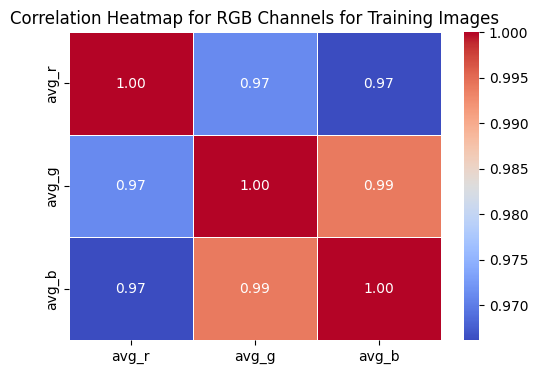

In [9]:
import seaborn as sns

def getChannelAverage(img,channel):
    return np.mean(img[:,:,channel])

df['avg_r']=df['image'].apply(lambda i:getChannelAverage(i,0))
df['avg_g']=df['image'].apply(lambda i:getChannelAverage(i,1))
df['avg_b']=df['image'].apply(lambda i:getChannelAverage(i,2))

# correlation matrix analysis
corr_mat=df[['avg_r','avg_g','avg_b']].corr()
print("-" * 50)
print("Confusion matrix for RGB intensities for each pixel:\n")
print(corr_mat)
print("-" * 50)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for RGB Channels for Training Images")
plt.show()

It is sparkling to see that all channels are almost linked to one another closely, with a correlation between any two close to 1, which means that when RGB values vary in a synchronized way from image to image or the values of the RGB satisfy a certain ratio. It is reasonable to conclude that even if we extract the grayscale information instead of extracting the information for the 3 channels, the model training step should not be impacted greatly. This is intuitive, because black-and-white images should work as well as colored images, and the machine only needs to take in the information of the shapes made by the hands in the images. By using grayscale instead of RGB channels reduces the number of channels from 3 to 1, which greatly reduces the overhead of the project.

Additionally, I decide to resize the images to (100,100), to reduce the burden on the GPU. To resize an image from 200 x 200 to 100 x 100, we make use of a Python function and the mechanism is probably averaging values or taking maximum values for neighbouring pixels, thereby voluntarily discarding details of image. In summary, the new image size becomes (100,100,1) become it should now have 100 x 100 pixels and only 1 channel. 
 
 #### 2.6 EDA: Label Distribution

After exploring the correlations among the RGB channels and taking decisions about using grayscale and resizing the images, we can also visualize the distribution of labels.

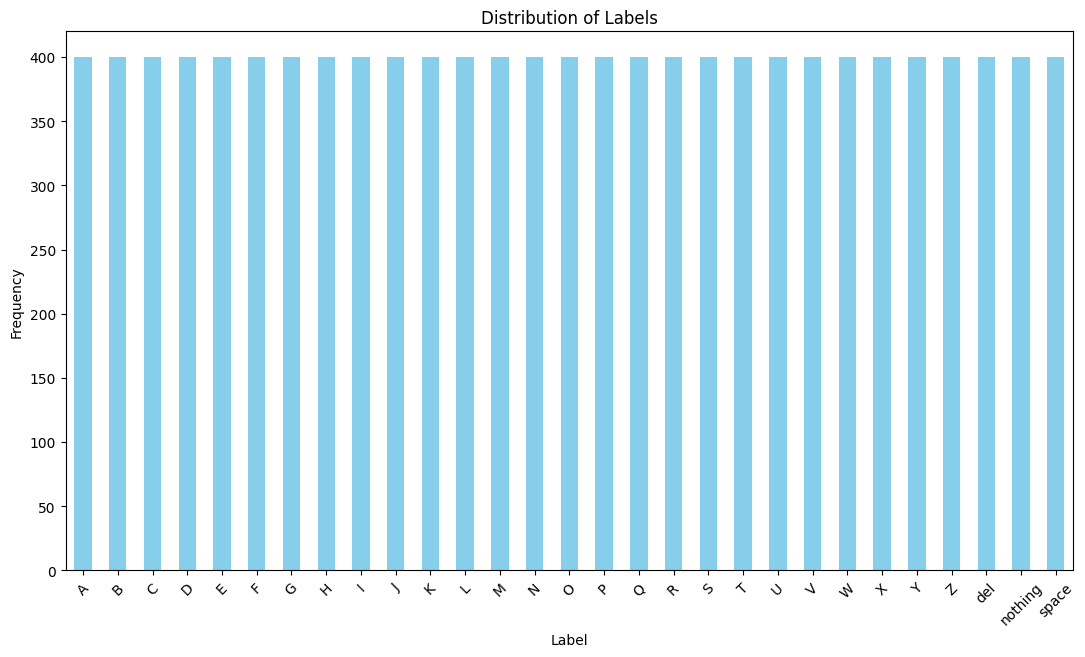

In [10]:
# bar plot for labels
label_freq = df['label'].value_counts().sort_index()
label_freq.plot(kind='bar', figsize=(13, 7), color='skyblue')
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

The distribution plot shows that the labels are perfectly evenly distributed, because my code is written to get exactly the same number of samples per character. This means that no labels are left out in our model training and that the trained model shall work equally well for all characters.

#### 2.7 EDA: One-hot Conversion of Labels

Recalling that we are dealing with 29 labels that are not numeric, it is possible to use one-hot matrices of size 29x1 with only one entry of 1 and the rest being 0, to represent the labels. For example, the letter A can be represented by an array of the first element being 1 preceding 28 0's; the letter B can be represented by the array for letter A, with the first two elements flipped. Nothing that the ASCII codes for the capital letters are consecutive integer from 65 and that in our one-hot matrix, they occupy the first 26 positions, it is possible to build our conversion function by making use of the ASCII codes and considering some exceptions for "del", "nothing" and "space".

In [11]:
# convert character to array
def convertLetterToOneHotMatrix(letter):
    mat=np.zeros(29)
    if letter=="del":
        mat[26]=1
    elif letter=="nothing":
        mat[27]=1
    elif letter=="space":
        mat[28]=1
    else:
        mat[ord(letter)-65]=1 # A=0, B=1, etc. Z=25
    return mat

# reverse conversion
def convertOneHotMatrixToLetter(mat):
    inx=np.argmax(mat)
    if inx==26:
        letter="del"
    elif inx==27:
        letter="nothing"
    elif inx==28:
        letter="space"
    else:
        letter=chr(inx+65)
    return letter

Up to this point, we have treated the images and labels completely, converting images to (100,100,1) matrices and labels to one-hot arrays with 29 boolean values that are subject to the condition that the sum of the array is equal to 1. We are ready to actually produce the two test DataFrames and one training DataFrame with our functions.

In [12]:
# obtain grayscale information instead of all RGB channels
df=getImagesAndLabels(path=r'/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train',
                     mode="L",resize=True)
df_test=getImagesAndLabelsForTest(path=r'/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test',
                     mode="L",resize=True)
df_test2=getImagesAndLabels(path=r'/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train',
                    mode="L",resize=True, debug=True, sample_size=20,training=False)

# test if the conversion works
print(convertOneHotMatrixToLetter(convertLetterToOneHotMatrix('B')))

X_train=np.array(df['image'].tolist())
y_train=np.array(df['label'].apply(convertLetterToOneHotMatrix).tolist())

X_test=np.array(df_test['image'].tolist())
y_test=np.array(df_test['label'].apply(convertLetterToOneHotMatrix).tolist())

X_test2=np.array(df_test2['image'].tolist())
y_test2=np.array(df_test2['label'].apply(convertLetterToOneHotMatrix).tolist())

print("-" * 50)
print("Sample data in the DataFrames:\n")
print(df.head(3))
print("\n" + "-" * 50)
print(f"Shape for training DataFrame: {df.shape}")
print("\n" + "-" * 50)
print(f"Shape for test DataFrame: {df_test.shape}")
print("\n" + "-" * 50)
print(f"Shape for test DataFrame for more accurate metrics: {df_test2.shape}")
print("\n" + "-" * 50)
print(f"Shapes for X_train, y_train, X_test, y_test, X_test2, y_test2: {df_test2.shape},{df_test2.shape},{df_test2.shape}," +
    f"{df_test2.shape},{df_test2.shape},{df_test2.shape}.")
print("-" * 50)

B
--------------------------------------------------
Sample data in the DataFrames:

  label                                              image
0     N  [[[0.12156863], [0.13333334], [0.12941177], [0...
1     N  [[[0.11764706], [0.13725491], [0.13333334], [0...
2     N  [[[0.12156863], [0.13725491], [0.14117648], [0...

--------------------------------------------------
Shape for training DataFrame: (11600, 2)

--------------------------------------------------
Shape for test DataFrame: (28, 2)

--------------------------------------------------
Shape for test DataFrame for more accurate metrics: (580, 2)

--------------------------------------------------
Shapes for X_train, y_train, X_test, y_test, X_test2, y_test2: (580, 2),(580, 2),(580, 2),(580, 2),(580, 2),(580, 2).
--------------------------------------------------


To summarize, all DataFrames have a shape of (Number of Images,2), where the "2" represents a column for images and another column for labels. The images have a size of (100,100,1), whilst the labels have an array representation of a size of (29,1).

The number of images in each DataFrame is shown as above. It is noted that the second test DataFrame has more samples than the first test DataFrame, because we want to use less data during the model training to reduce overhead, while we want to use more data to evaluate the models for more precise metrics.

## 3. Model Training and Hyperparameter Tuning

Now that the training data and validation data are ready, we can start designing our model and start our hyperparameter tuning.

With library keras, model training and hyperparameter tuning can be merged together, since it allows us to build layers with variable hyperparameters. First of all, in the model, there should be an input layer expecting inputs of shape of (100,100,1). After that, there should be convolutional layers, with different numbers of filters of different sizes. To flesh out a bit from here, 3 x 3 and 5 x 5 are commonly used filter sizes, and it is a common rule to start from smaller numbers of filters and to increase the number of filters later. In my design, I will have three convolutional layers, each having respectively around 16, 32 and 64 filters. Since I am not sure what filter size to use, I will put both 3 x 3 and 5 x 5 and choices for the tuner; by the way, I leave out 7 x 7 which could also be an option, to lighten the load for calculation. I choose 'relu' as the activation function since it is the most common one; however, for future reference, we can change the choice of activation function to improve the model performance.

To improve the efficiency and effectiveness of the model, I can moderately add some pooling and batch normalization layers. It is almost a rule for me to perform one batch normalization after each convolutional layer, for the fact that it can smooth out the variation brought about by the activation function, which stabilizes the model and augments the calculation speed. On the other hand, I decide to add a pooling layer after all the three convolutional layers, since it is recommended to add one pooling after several convolutional layers to reduce the number of variables and to speed up the iterations, which helps the model to accelerate the calculation whilst preserving some meaningful features. Concretely, I choose 2 x 2 as the pooling size and max pooling as my pooling method.

After the convolutional layers, batch normalization and pooling, we should not forget to convert the intermediate variables into a one-hot array of a size of 29. To achieve so, we can flatten the matrix to make it 1-D, further add a dense layer to reduce the number of variables and another dense layer to convert the previous dense layer into one array containing only 29 values. To achieve so, I can vary the number of dense units in the first dense layer, but set the number of units in the second dense layer to be 29 to ensure the size of the output. I choose softmax as the activation function for the second dense layer since this is a multicategorical problem, and the function yields the probability for the output to fall into any of the labels. Despite we are getting probabilities, we can easily apply np.argmax() to find out the most likely label, which will be the prediction of the model.

Moreover, we can add some dropout layers to prevent overfit, and I choose to add one dropout layer between the two dense layers. 

Last but not least, to select the optimal model, I choose 'adam' as the optimizer, with a variable learning rate to determine the best learning rate. Additionally, for the nature of the problem, we will use categorical cross entropy as the loss function to adjust the hyperparameters during iterations. I also added some lines in the codes to modify the precision policy and clear memories, to reduce the memory cost.

I would like to highlight that the ranges and values for hyperparameters might be different from what is mentioned above, since the values mentioned above are nothing but my initial guesses based on my experience working as a data scientist. As a matter of fact, I modify their values as I proceed with some attempts and examine how models react faced with changes in the hyperparameters, which is the reason why the values in the following code might be largely different from my initial guesses.

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras_tuner.tuners import Hyperband
from keras_tuner import HyperModel
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision

# use mixed precision to reduce memory use
mixed_precision.set_global_policy('mixed_float16')

# call back function to record the accuracies and losses
class TrainingHistory(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses=[]
        self.test_losses=[]
        self.train_accuracies = []
        self.test_accuracies = []

    def on_epoch_end(self,epoch,logs=None):
        self.train_losses.append(logs['loss'])
        self.test_losses.append(logs['val_loss'])
        self.train_accuracies.append(logs['accuracy'])
        self.test_accuracies.append(logs['val_accuracy'])
        
        K.clear_session() # to save memory and prevent memory leak

    def on_train_end(self,logs=None):
        K.clear_session() # to save memory and prevent memory leak

# design of deep learning model with ranges of hyperparams
class SignLanguageCNNHyperModel(HyperModel):
    def build(self,hp):
        model=models.Sequential()
        
        # input layer + first convolution
        model.add(layers.InputLayer(shape=(100,100,1)))
        model.add(layers.Conv2D(filters=hp.Int('conv1_num_filters',min_value=64,max_value=64,step=64),# max_value=32
                               kernel_size=hp.Choice('conv1_size_filter',values=[3#,5
                                                                                ]),
                               activation='relu'))
        model.add(layers.BatchNormalization())

        # second convolution
        model.add(layers.Conv2D(filters=hp.Int('conv2_num_filters',min_value=64,max_value=128,step=64), # max_value=64
                               kernel_size=hp.Choice('conv2_size_filter',values=[#3,
                                                                                 5
                                                                                ]),
                               activation='relu'))
        model.add(layers.BatchNormalization())

        # third convolution
        model.add(layers.Conv2D(filters=hp.Int('conv3_num_filters',min_value=128,max_value=256,step=64), 
                               kernel_size=hp.Choice('conv3_size_filter',values=[#3,
                                                                                5
                                                                                ]),
                               activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

        # dense layers
        model.add(layers.Flatten())
        model.add(layers.Dense(units=hp.Int('num_dense_units',min_value=128,max_value=128,step=64),activation='relu')) # min_value=16
        model.add(layers.Dropout(rate=hp.Float('dropout_rate',min_value=0.2,max_value=0.2,step=0.1))) # max_value=0.7

        model.add(layers.Dense(29, activation='softmax'))

        # compilation config
        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, sampling='log')), # we can use higher learning rate to accelerate convergence
            loss='categorical_crossentropy',
            metrics=['accuracy',tf.keras.metrics.Recall(name="recall")])
        return model

# hypertuning and obtention of the best hyperparams + best model
K.clear_session()
signLanguageCNN = SignLanguageCNNHyperModel()
tuner=Hyperband(signLanguageCNN,objective='val_accuracy',max_epochs=8
                ,directory='',project_name='',overwrite=True)
tuner.search(X_train,y_train,
             epochs=8,
             validation_data=(X_test,y_test),
             batch_size=8) # we can reduce batch size to reduce memory use

best_trained_model=tuner.oracle.get_best_trials(num_trials=1)[0]
best_hps=best_trained_model.hyperparameters
best_model=signLanguageCNN.build(best_hps)

print("-" * 50)
for p,v in best_hps.values.items():
    print(f" - {p}:{v}")
print("-" * 50)

best_model.summary()

hist_callback=TrainingHistory()
hist=best_model.fit(X_train,y_train,epochs=8,validation_data=(X_test,y_test),callbacks=[hist_callback])

Trial 10 Complete [00h 06m 33s]
val_accuracy: 0.2857142984867096

Best val_accuracy So Far: 0.9642857313156128
Total elapsed time: 00h 47m 24s
--------------------------------------------------
 - conv1_num_filters:64
 - conv1_size_filter:3
 - conv2_num_filters:64
 - conv2_size_filter:5
 - conv3_num_filters:192
 - conv3_size_filter:5
 - num_dense_units:128
 - dropout_rate:0.2
 - learning_rate:1.0544977015977334e-05
 - tuner/epochs:8
 - tuner/initial_epoch:3
 - tuner/bracket:1
 - tuner/round:1
 - tuner/trial_id:0002
--------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 98, 98, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 98, 98, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 94, 94, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 94, 94, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 192)         │         307,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 90, 90, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 388800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      49,766,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,182,045 (191.43 MB)

 Trainable params: 50,181,405 (191.43 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/8
363/363 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.2196 - loss: 2.9269 - recall: 0.0897 - val_accuracy: 0.0714 - val_loss: 4.7181 - val_recall: 0.0357
Epoch 2/8
363/363 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.5355 - loss: 1.5613 - recall: 0.3963 - val_accuracy: 0.9286 - val_loss: 0.4391 - val_recall: 0.7857
Epoch 3/8
363/363 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.6778 - loss: 1.0770 - recall: 0.5550 - val_accuracy: 0.7857 - val_loss: 0.4737 - val_recall: 0.7857
Epoch 4/8
363/363 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.7729 - loss: 0.7286 - recall: 0.6817 - val_accuracy: 0.9643 - val_loss: 0.1842 - val_recall: 0.9286
Epoch 5/8
363/363 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.8466 - loss: 0.4946 - recall: 0.7803 - val_accuracy: 0.8929 - val_loss: 0.2996 - val_recall: 0.8929
Epoch 6/8
363/363 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8914 - loss: 0.3497 - recall: 0.8439 - val_accuracy: 0.8929 - val_loss: 0.3245 - val_recall: 0.892

To explore which hyperparameters work the best without wasting much time, I used only a small portion of data and increased the data size gradually, while I adjusted the ranges for hyperparameters according to my results; for example, I started with 15 images per character, then 100 images per character, etc. This iterative process helped me get a better understanding on how different hyperparameters impact the performance of the model, allowing me to narrow the search ranges for the tuner. Furthermore, this allows me to reduce memory cost and overhead, successfully accelerating the convergence and enhancing the efficiency of the model training step.

Since the GPU is quite limited, I could not go all the way up to 3000, but including a considerable amount of training data should be sufficient to build an acceptable model. That being said, the code above is somehow a tip of iceberg for my whole exploration, since I adjusted the training data size and hyperparameters numerous times, before ending up with reasonable ranges and well-performing models.

Here follow some concrete steps for the iterative step. In the beginning, it was quite frustrating to see that the accuracy stays below 10% for most of the time when I use only less than 10 samples for each character, while it was absolutely euphoric to see the accuracy to rise up beyond 10%, then 15% and then up to 17.85%, after I increased the size of sample to 30 for each character. 

Observing the best hyperparameters, I adjusted the ranges for the hyperparameters and increased the sample sizes. For example, I started using a very low learning rate and more filters for all three convolutional layers, because those hyperparameters lead to high performance of the model. After I used 100 samples per character, the best validation accuracy rose to 78.57%. Finally, I increased the sample size to 400 per character, and this time, I was able to obtain a validation accuracy of close to 96.5%, which was satisfactory.

## 4. Evaluation and Discussion

From the hyperparameter tuning step using accuracy as a criterium, we have obtained the best set of hyperparameters and the best model. To evaluate the performance of the model, we can do the following:

1. Check if there is overfit by plotting accuracy vs epochs
2. Evaluate the predictions: using the test data, we can approximately evaluate the obtained model; certainly, I could even make a gesture myself, take a photo and resize it to the desired size to test out the model, which I might do in the future

Normally, for a multi-label classification problem, I would carry out a confusion matrix analysis. However, considering that the size of test dataset, I will only include the function to do so, maybe for future use, but will not apply it to this project. There are other criteria for evaluation that might interest us like recall, F1-score; we will discuss about the accuracy and the recall in the following section.

[0.30603447556495667, 0.555344820022583, 0.6938793063163757, 0.778534471988678, 0.8438792824745178, 0.8908620476722717, 0.9187930822372437, 0.9356896281242371]


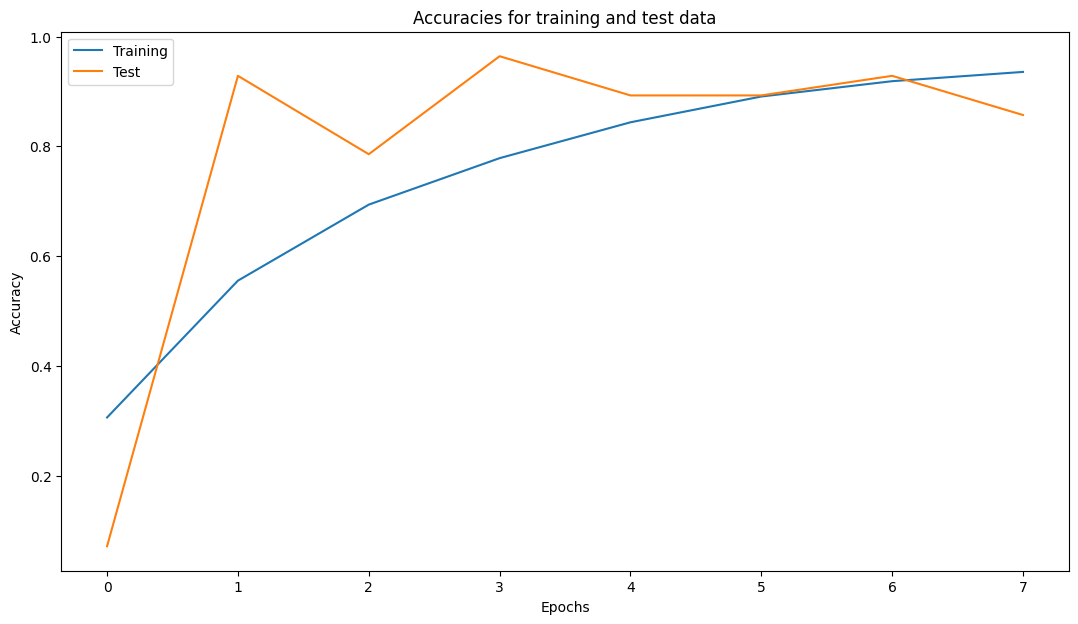

[2.4738521575927734, 1.4760154485702515, 1.010103702545166, 0.7100399136543274, 0.5012117624282837, 0.3496053218841553, 0.26102516055107117, 0.20733964443206787]


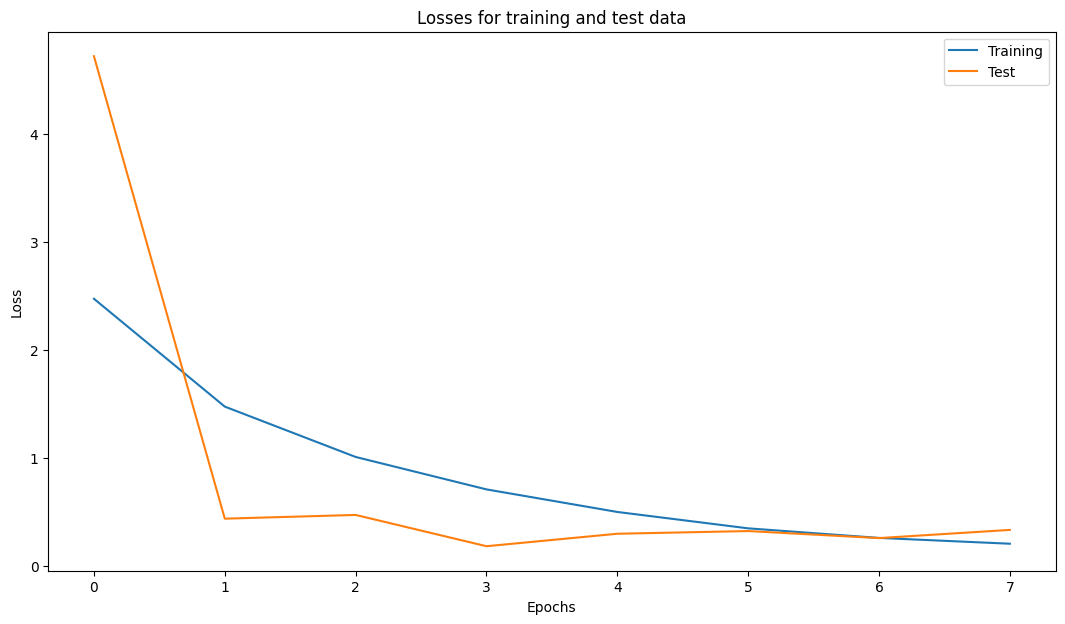

In [14]:
from sklearn.metrics import confusion_matrix

# plot accuracy evolution in the best run
print(hist_callback.train_accuracies)
plt.figure(figsize=(13,7))
plt.plot(hist_callback.train_accuracies, label=f'Training')
plt.plot(hist_callback.test_accuracies, label=f'Test')
plt.title(f'Accuracies for training and test data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot loss evolution in the best run
print(hist_callback.train_losses)
plt.figure(figsize=(13,7))
plt.plot(hist_callback.train_losses, label=f'Training')
plt.plot(hist_callback.test_losses, label=f'Test')
plt.title(f'Losses for training and test data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As is shown from the plots above, for the best run, it takes around 4-5 epochs for the test and training accuracies to rise and become stable; on the other hand, it takes around 4-5 epochs for the losses to go down and stay stable. In both plots, we see that at Epochs=7, the test accuracy does not have a significant dropping tendency, and nor does the test curve for loss show a tendency to climb up, which is a good sign, because this means that there is little to no overfit in the model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step - accuracy: 0.9643 - loss: 0.0733 - recall: 0.9643
Metrics for the best model: Accuracy = 96.43% Loss = 0.0733 Recall = 0.9643
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
--------------------------------------------------
Confusion matrix for test data:

[[18  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 2 14  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0
   0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  1  1 17  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 3  1  0  1 10  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  1  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0]
 [ 0  0  0  0  0  1 13  3  1  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  2  0  0  0  0  0  1  0  0  0  0  0  

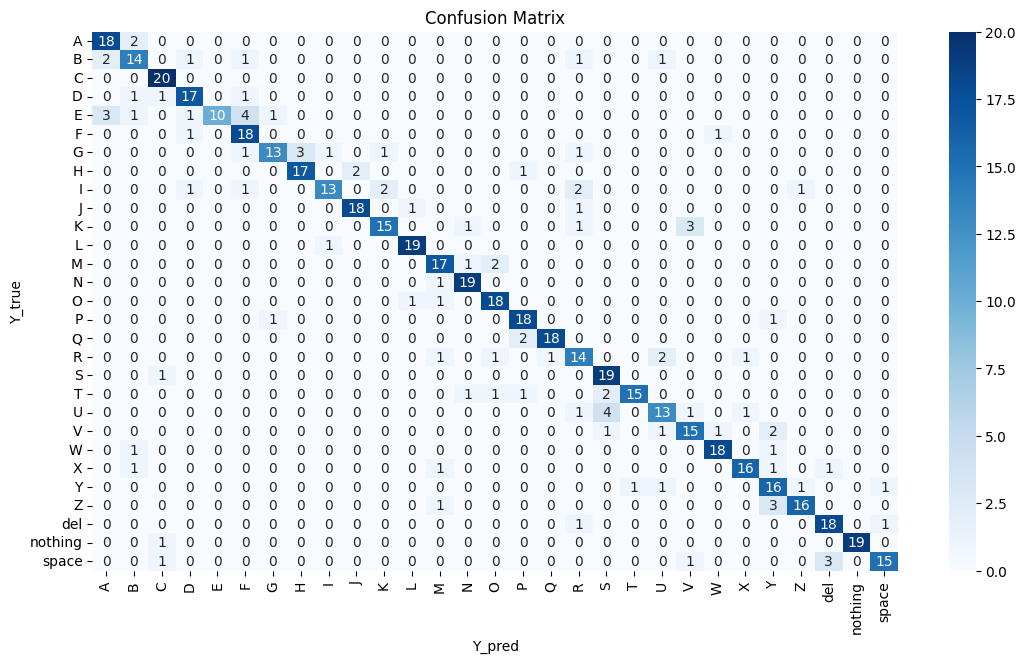

In [15]:
# loss, accuracy and recall with our second test data (with more samples)
model = tuner.get_best_models(num_models=1)[0] 
loss, acc, recall = model.evaluate(X_test, y_test)
print(f"Metrics for the best model: Accuracy = {acc:.2%} Loss = {loss:.4f} Recall = {recall:.4f}")

# confusion matrix 
def confusionMatrixAnalysis(y_true,y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    print("-" * 50)
    print("Confusion matrix for test data:\n")
    print(cm)
    print("-" * 50)
    
    plt.figure(figsize=(13,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Y_pred')
    plt.ylabel('Y_true')
    plt.title('Confusion Matrix')
    plt.show()

pred=best_model.predict(X_test2)
#print(pred)
y_pred=[convertOneHotMatrixToLetter(one_hot) for one_hot in pred]
y_true=[convertOneHotMatrixToLetter(one_hot) for one_hot in y_test2]
class_labels = sorted(set(y_true) | set(y_pred))
confusionMatrixAnalysis(y_true,y_pred, class_labels)

From the best validation accuracy of 96.43%, we can tell that the model works very well in general, predicting most of the characters correctly from the images. 

From the confusion matrix, it is a good sign to see that most of the diagonal values are close to 20, which is the sample size for the second test DataFrame. However, for those values that are relatively far from 20, we can see what they are mistaken for. The confusion matrix shows us the model performs well for some characters, while the model performs worse for the other characters (G and E, for example), which might be meaningful for us to introduce more data for those characters for which the model fails to identify with a high success rate.

## 5. Conclusion

In this project, we made attempts to explore the possibility of applying deep learning to capture the patterns in images showing signs for a given sign language. In the EDA process, we discovered that analyzing RGB channels did not provide more information compared to grayscale, for which we decided to extract grayscale information from the images, which was later reduced in proportion in size to reduce overhead. I also discussed on methodologies to deal with duplicates and outliers for those images.

During the model training process, an input layer, three layers of convolution, a flattening step and two dense layers to produce the label output as a one-hot matrix, were included in the model as a base, on which I added dropout, pooling and batch normalization where it is appropriate to improve efficiency and avoid overfit. With the help of keras, I was able to search for the best parameters and as a result, I obtained a well-performing model yielding an accuracy of close to 96.5%. To tune the hyperparameters efficiently, I adjusted the ranges for tuning search as I increased the training data size form 5, to 10, to 30, to 100, etc., and as a result, the model converged more quickly and I observed an validation accuracy going up constantly. Considering that I have only used a small portion of the data to train the model, due to limitations such as the GPU performance and deadline for this project, I will be able to make this accuracy as close as possible to 99%, even 100%, in the future, given enough time for such a complex project.

To evaluate the model, I plotted the losses and accuracy for training data and test data over epochs, from which we could discern that there was probably very small to no overfit. From the validation accuracy and recall, we can tell that basically this deep learning project has been a success. Despite that, there are many aspects on which we should work on, in order to enhance the performance of the model and the efficiency of the training process. 

Firstly, I think bias might be a problem for this project, because I find images somehow similar to one another probably due to the fact that similar devices were used to generate them. Thereby, I wonder if the model will still work well if new data generated by different devices are introduced; or in other words, I think we should train the model by randomly mixing in some new images taken by different devices under different lighting conditions. Additionally, different filters can be added to the distort the images, which can be fed to the model later to train the model, so that it can recognize the gestures despite bad light exposure and other disturbing noises. 

Secondly, it might be interesting to apply the concept of generative AI, which means that we should build a generator that is capable of generating images with a gesture, and train it at the same time with our model, so that the two models can grow at the same time. The advantage of doing so is that the generative model will be able to continuously provide training samples to our model to push the accuracy to quasi perfection, despite the considerable costs linked with the architecture of a generative-discriminative model pair.

Thirdly, in order to finish the project before the deadline, I omitted several steps, which might have a considerable impact on the outcomes. We could exclude duplicates and outliers before the training step; in addition, we should probably make use of function to include unused images in the training folder to the test dataset.

Fourthly, according to the confusion matrix, we identified some characters such as "E" or "G", for which the model did not predict very well. Faced with this issue, we might want to introduce more samples for those characters to enhance the prediction performance for them.

Last but not least, it is possible to change the design of the model or to explore the hyperparameters that we did not look at in the discussion. I ask myself these questions:

1. Is it reasonable to introduce more convolutional layers? What is the optimal number of convolutional layers without inducing too much overfit? If we do not resize the images, what will be the optimal number of convolutional layers? How about the dense layers? Will it be interesting to add in even more dense layers before producing the final output?
2. Why don't we try filters of size 7 x 7? What if we add a scheduler for the learning rate? Will it be of our interest to vary the pooling size? Can we obtain a even better model by enlarging the ranges for dropout, filter size, learning rate, etc.?

There are many questions and problems yet to be solved; however, undoubtedly this project has been a success, which will surely guide us through further steps to produce a reliable and commercializable sign language translator in the future.